# making figure sfor ACE

Figure 1: conceptual figure  
1a: showing off pretraining of model  
1b: showing off evaluation of model  
1c: showing model architecture of multiple species  
1d: showing how to interpret motifs of models

Figure 2: preliminary results  
2a: dsQTL results with enformer borzoi and chrombpnet  
2b: eQTL results with them

In [ ]:
#we need to get example input and output values for dsQTL to understand it

#so with input we just show true value and masked input. Then for output we show a third one which is predicted

#then for 1b we show the same input but we show it with the variant and with the standard and then compare them!

#can easily make it work by simply inputting the modified sequences into the model
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import pandas as pd
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
#some other things to load in
import numpy as np
genome = np.load('/data1/lesliec/sarthak/data/chrombpnet_test/hg38_tokenized.npz')
genome_loaded = {}
for key in genome:
    genome_loaded[key] = genome[key][:]

bims = {}
for i in range(1,23):
    bim_path = f'/data1/deyk/extras/1000G_BIMS_hg38/1000G.EUR.QC.{i}.bim'
    bim = pd.read_csv(bim_path, sep='\t', header=None)
    bims[i] = bim
    
bim_pos = {
    chrom: dict(zip(bims[chrom][1].values, bims[chrom][3].index))
    for chrom in bims
}
bim_pos #just maps the rsid and chromosome to the index in the bim file
#now we can load our model in
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path, device=1)
#now what we do is we loop through, get the positions, then we can evaluate it

# qtls.iloc[0]
rsid = qtls.iloc[0]['SNPname2']
chrom = qtls.iloc[0]['chrom_hg19']
bimrow = bim_pos[int(chrom[3:])][rsid]
bimval = bims[int(chrom[3:])].iloc[bimrow]
bimval
# (qtls['chrom_hg19'] == qtls['chrom_hg18']).value_counts() #good at least the chromosome matches lol, and a single mismatch with hg38 bims, but it's fine!
midpoint = bimval[3]-1
start = midpoint - 524288//2
end = start + 524288
# chrom = bimval[0]
print(start,end,chrom)



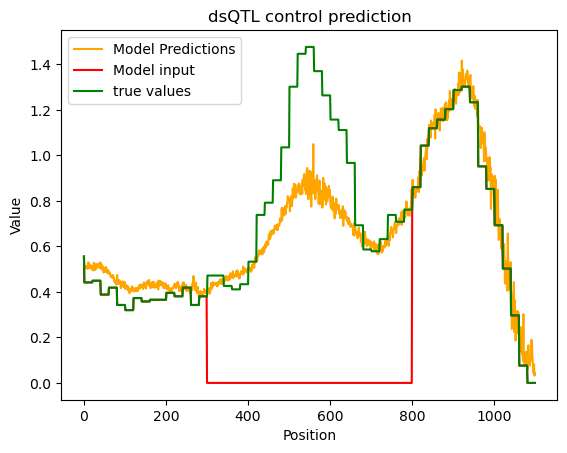

In [3]:
#can do checks like asserting chrom matches, or just leave as is?
idx = evals.dataset.expand_seqs(chrom,start,end)
data = evals.dataset[idx]
# data[0][0].shape, data[0][1].shape, data[1][0].shape, data[1][1].shape
si = 524288//2 - 250
se = 524288//2 + 250
out = evals.mask(si,se, idx, mask_accessibility=True)
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
# plt.axvline(x=mi+5-si+300, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('dsQTL control prediction')
plt.legend()

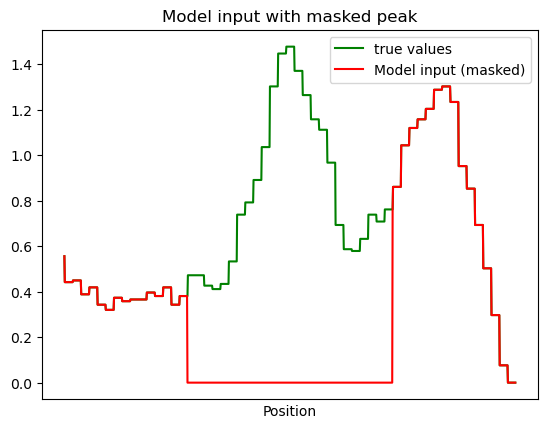

In [ ]:
# plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input (masked)', color='red')
plt.xlabel('Position')
#remove x ticks
plt.xticks([])
plt.title('Model input with masked peak')
plt.legend()

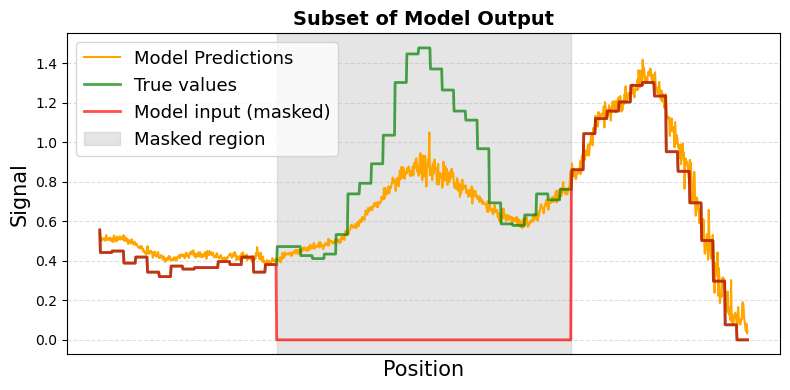

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot both lines with alpha for clarity
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
ax.plot(out[-3][si-300:se+300, 0], label='True values', color='green', linewidth=2, alpha=0.7)
ax.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input (masked)', color='red', linewidth=2, alpha=0.7)

# Shade the masked region
mask_start = 300
mask_end = 300 + (se - si)
ax.axvspan(mask_start, mask_end, color='gray', alpha=0.2, label='Masked region')

# Axis styling
ax.set_xlabel('Position', fontsize=15)
ax.set_ylabel('Signal', fontsize=15)
ax.set_title('Subset of Model Output', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=13)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [21]:
modified_input = out[2].clone()
modified_input[524288//2,0] = 0 #set A to 0
modified_input[524288//2,2] = 1 #set G to 1
modified_input[524288//2]

data = (None,None,modified_input,out[3])

out2 = evals.mask(si,se, data=data, mask_accessibility=True)

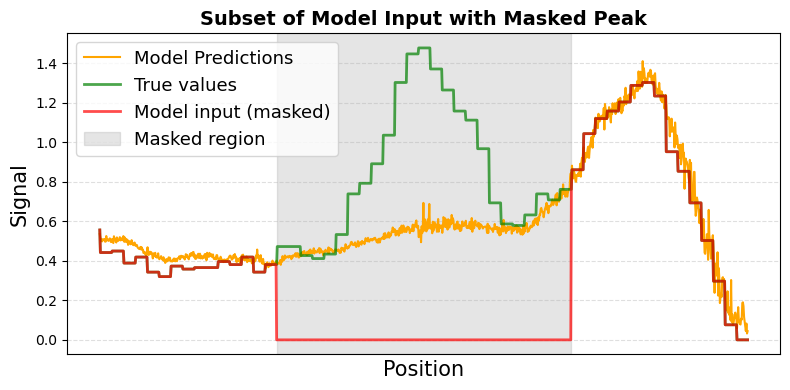

In [23]:
#now do the same but show the predicted region too

fig, ax = plt.subplots(figsize=(8, 4))

# Plot both lines with alpha for clarity
plt.plot(out2[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
ax.plot(out[-3][si-300:se+300, 0], label='True values', color='green', linewidth=2, alpha=0.7)
ax.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input (masked)', color='red', linewidth=2, alpha=0.7)

# Shade the masked region
mask_start = 300
mask_end = 300 + (se - si)
ax.axvspan(mask_start, mask_end, color='gray', alpha=0.2, label='Masked region')

# Axis styling
ax.set_xlabel('Position', fontsize=15)
ax.set_ylabel('Signal', fontsize=15)
ax.set_title('Subset of Model Input with Masked Peak', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=13)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# figure 1c

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import pandas as pd
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
#some other things to load in
import numpy as np
genome = np.load('/data1/lesliec/sarthak/data/chrombpnet_test/hg38_tokenized.npz')
genome_loaded = {}
for key in genome:
    genome_loaded[key] = genome[key][:]

bims = {}
for i in range(1,23):
    bim_path = f'/data1/deyk/extras/1000G_BIMS_hg38/1000G.EUR.QC.{i}.bim'
    bim = pd.read_csv(bim_path, sep='\t', header=None)
    bims[i] = bim
    
bim_pos = {
    chrom: dict(zip(bims[chrom][1].values, bims[chrom][3].index))
    for chrom in bims
}
bim_pos #just maps the rsid and chromosome to the index in the bim file
#now we can load our model in
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path, device=3)
#now what we do is we loop through, get the positions, then we can evaluate it

# qtls.iloc[0]
rsid = qtls.iloc[0]['SNPname2']
chrom = qtls.iloc[0]['chrom_hg19']
bimrow = bim_pos[int(chrom[3:])][rsid]
bimval = bims[int(chrom[3:])].iloc[bimrow]
bimval
# (qtls['chrom_hg19'] == qtls['chrom_hg18']).value_counts() #good at least the chromosome matches lol, and a single mismatch with hg38 bims, but it's fine!
midpoint = bimval[3]-1
start = midpoint - 524288//2
end = start + 524288

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [3]:
evals.dataset[0][0][0].shape

torch.Size([6, 524288])

In [4]:
evals.dataset.data['chr1'].shape

(1, 248956422)

In [6]:
seq = evals.dataset.data[chrom][0,start:end]
seq.shape

(524288,)

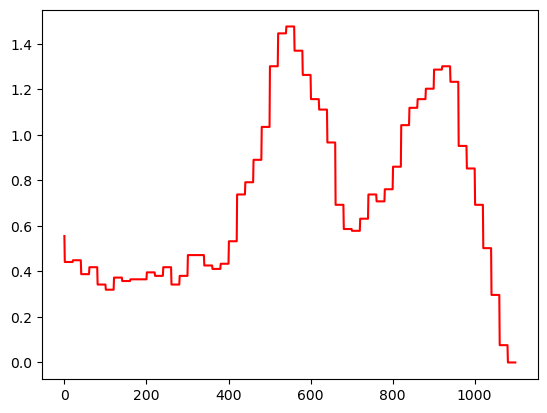

In [9]:
si = 524288//2 - 250
se = 524288//2 + 250

plt.plot(seq[si-300:se+300], label='Model input', color='red')

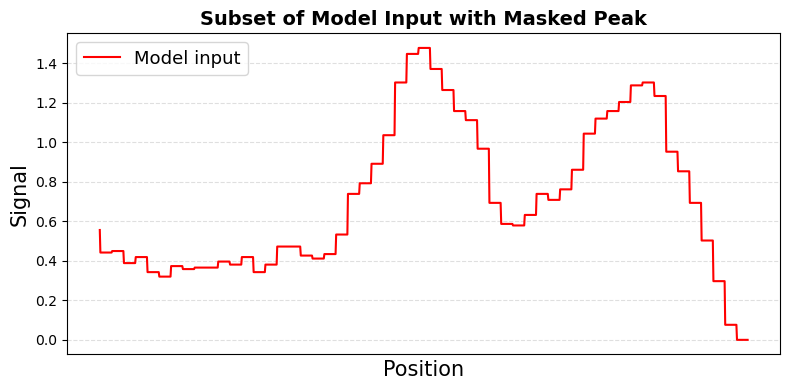

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot both lines with alpha for clarity
ax.plot(seq[si-300:se+300], label='Model input', color='red')

# Axis styling
ax.set_xlabel('Position', fontsize=15)
ax.set_ylabel('Signal', fontsize=15)
ax.set_title('Subset of Model Input with Masked Peak', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=13)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

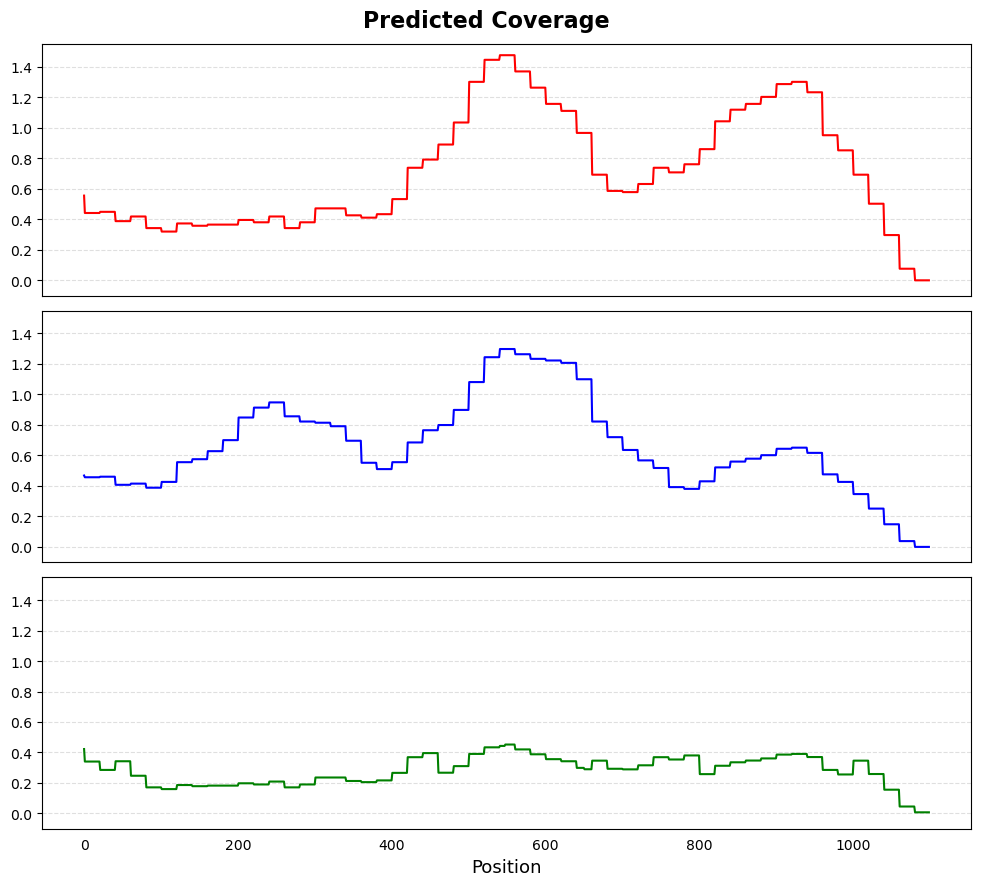

In [29]:
original = seq[si-300:se+300]
x = np.arange(len(original))

# === Function to add proportional noise to constant-value intervals ===
# def add_segmented_noise(data, noise_scale=0.1):
#     noisy = data.copy()
#     start = 0
#     for i in range(1, len(data)):
#         if data[i] != data[i-1] or i == len(data) - 1:
#             end = i
#             value = data[start:end]
#             base_val = value[0]
#             # Add proportional noise
#             noise = np.random.normal(loc=0, scale=noise_scale * abs(base_val), size=end - start)
#             noisy[start:end] = base_val + noise
#             start = i
#     return noisy

# Create noisy and noisy-scaled versions
# noisy = add_segmented_noise(original, noise_scale=0.1)
noisy = (original*2 + seq[si-300+300:se+300+300]*2)/4
noisy_scaled = (original*2 + seq[si-300+1000:se+300+1000]*2)/4
#values above 0.4 get scaled down
noisy_scaled[noisy_scaled > 0.4] *= 0.6

# === Plotting ===
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# 1. Original
axs[0].plot(x, original, color='red', label='Original')
# axs[0].set_title('Original', fontsize=14, fontweight='bold')

# 2. Noisy
axs[1].plot(x, noisy, color='blue', label='Noisy')
# axs[1].set_title('Noisy (Segment-wise Proportional)', fontsize=14, fontweight='bold')

# 3. Noisy + Scaled
axs[2].plot(x, noisy_scaled, color='green', label='Noisy + Scaled')
# axs[2].set_title('Noisy + Scaled (×0.8)', fontsize=14, fontweight='bold')

# Style all
for ax in axs:
    # ax.set_ylabel('Signal', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # ax.legend(loc='upper left', fontsize=11)
    #set y axis to the same range, -.1 to 1.5
    #turn off y ticks
    # ax.set_yticks([])
    ax.set_ylim(-0.1, 1.55)

axs[-1].set_xlabel('Position', fontsize=13)
axs[-1].tick_params(axis='x', labelbottom=True)

#set super title
plt.suptitle('Predicted Coverage', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# figure 2a

In [1]:
#let's go ahead and make this one with the dsQTL results


#want to use the same models that we trained with eQTL

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2



qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/dsQTL/filtered_dsqtls.txt', sep='\t')
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def softmax(x, temp=1):
    norm_x = x - np.mean(x, axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

def predict_snp_effect_scores_bpnet(ref_prob_preds, alt_prob_preds, ref_count_preds, alt_count_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    
    print(ref_prob_preds.shape, alt_prob_preds.shape, ref_count_preds.shape, alt_count_preds.shape)
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    #and account for nan
    log_probs_diff_abs_sum[np.isnan(log_probs_diff_abs_sum)] = 0
    # probs_jsd_diff = np.array([jensenshannon(softmax(x),softmax(y)) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    probs_jsd_diff = np.squeeze([jensenshannon(x, y, base=2.0)
                     for x,y in zip(softmax(alt_prob_preds),
                                    softmax(ref_prob_preds))])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_count_preds/alt_count_preds)[:,0]
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2
    
labels = qtls['label'].to_numpy()

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        if 'npz' in file:
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(pred_cbp['profile'][:,:,0], pred_cbp['profile'][:,:,1], pred_cbp['counts'][:,:,0], pred_cbp['counts'][:,:,1])
        
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:,440:456,:]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{titles[i]} (AUC = {pr_auc:.3f})'))

    plt.title(title if title else f'Precision-Recall Curve for {metric_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_979933/832714817.py:100: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


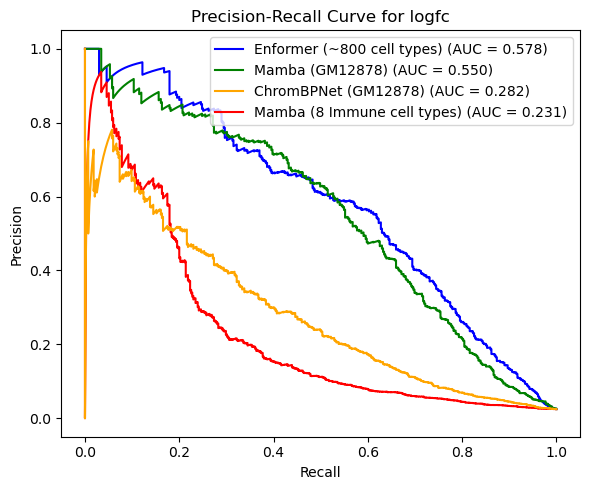

In [5]:
files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'immune_all_2.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=True, enformer_center=True, titles=titles, title='Precision-Recall Curve for logfc')

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_3546224/832714817.py:100: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


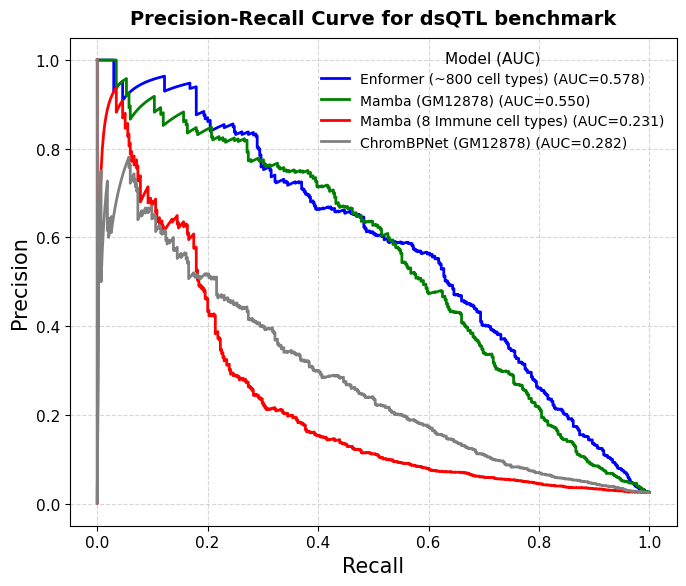

In [5]:
#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'green', 'red', 'gray', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'immune_all_2.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_486234/832714817.py:100: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


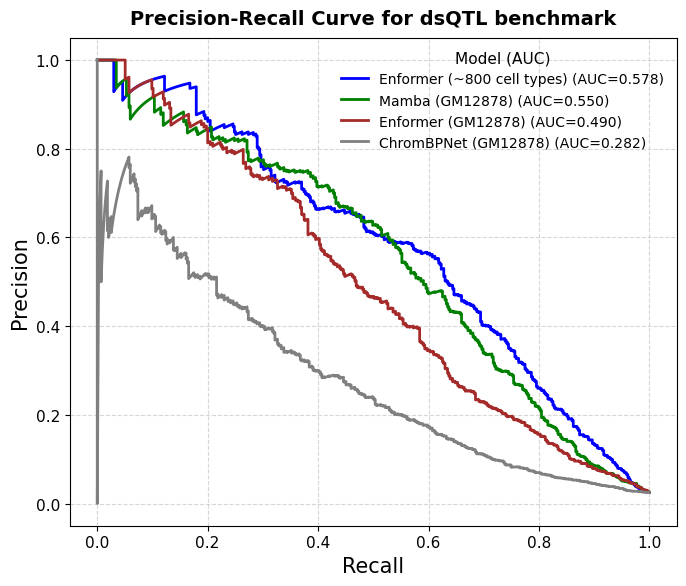

In [5]:
#A slightly different version where we don't use mamba 8 cell types but isntead use Enformer on 1 cell type

#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'green', 'brown', 'gray', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'enformer_dsqtl_retrained-dsqtl.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Enformer (GM12878)', 'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

(17506, 1000) (17506, 1000) (17506, 1) (17506, 1)


/tmp/ipykernel_2049276/832714817.py:100: RuntimeWarning: invalid value encountered in log
  log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)


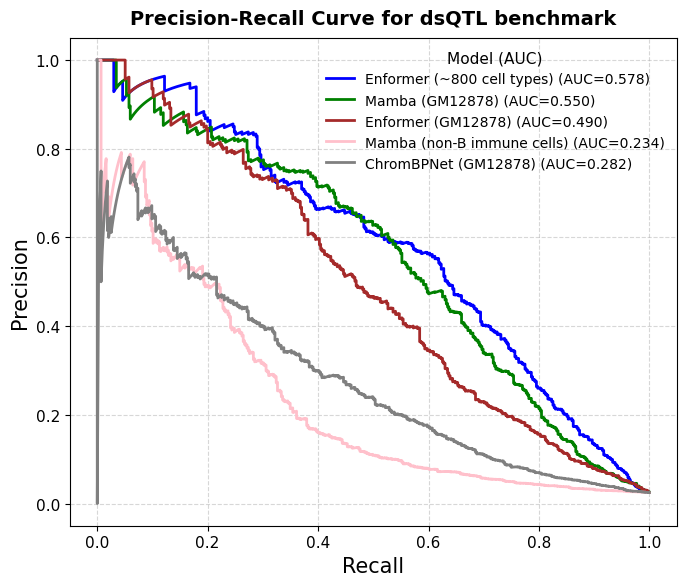

In [4]:
#A slightly different version where we don't use mamba 8 cell types but isntead use Enformer on 1 cell type

#make it look better
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=False, titles=None, title=None):
    """
    Plots publication-ready Precision-Recall curves for selected SNP effect metrics.
    """
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    # Set up the figure
    plt.figure(figsize=(7, 6))
    plt.rcParams.update({'font.size': 11})

    # Color cycle and line style
    # color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    line_width = 2

    colors = ['blue', 'green', 'brown', 'pink', 'gray', 'brown', 'pink', 'gray', 'olive', 'cyan']

    legend_entries = []

    # Plot each model's PR curve
    for i, file in enumerate(files):
        if file.endswith('.npz'):
            pred_cbp = np.load('/data1/lesliec/sarthak/data/joint_playground/chrombpnet/GM12878_Tcellbias/var_prds.npz')
            out = predict_snp_effect_scores_bpnet(
                pred_cbp['profile'][:, :, 0],
                pred_cbp['profile'][:, :, 1],
                pred_cbp['counts'][:, :, 0],
                pred_cbp['counts'][:, :, 1]
            )
        else:
            eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/dsQTL/{file}')
            if enformer_center and 'enformer' in file:
                eqtl_data = eqtl_data[:, 440:456, :]
            out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        scores = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], scores)
        pr_auc = auc(recall, precision)

        line, = plt.plot(
            recall,
            precision,
            label=titles[i] if titles else file,
            color=colors[i],
            linewidth=line_width
        )
        legend_entries.append((pr_auc, line, f"{titles[i]} (AUC={pr_auc:.3f})"))

    # Format title and labels
    plt.title(
        title or f'Precision–Recall Curve ({metric_name.upper()})',
        fontsize=14,
        fontweight='bold',
        pad=10
    )
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

    # Grid for readability
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Sort legend by AUC if requested
    if sort_legend_by_auc:
        legend_entries.sort(key=lambda x: x[0], reverse=True)
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    # Legend styling
    plt.legend(
        handles,
        labels_sorted,
        title='Model (AUC)',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',
        frameon=False
    )

    # Tight layout and display
    plt.tight_layout()
    plt.show()

files = ['enformer_dsqtl.npy', 'nomlm_maskonly.npy', 'enformer_dsqtl_retrained-dsqtl.npy', 'immune_nob_2.npy', '.npz']
titles = ['Enformer (~800 cell types)', 'Mamba (GM12878)',
                    'Enformer (GM12878)', 'Mamba (non-B immune cells)', 'ChromBPNet (GM12878)']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, enformer_center=True, titles=titles, title='Precision-Recall Curve for dsQTL benchmark')

# figure 2b

In [5]:
#let's first load in the data and create these bar plots again but make it cleaner

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()


qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()

def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title='', mask=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - center[i] // 2
            center_end = center_start + center[i]
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if mask is None: #can supply a mask or can use default mask of the first value!
            if i == 0:
                non_zero_mask = (out[0] != 0)
        else:
            non_zero_mask = mask

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()
    
import pickle
base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
with open(base_dir+'genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)

ordered_genes = sorted(list(gene_annotation.keys()))

tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}

distances = np.zeros((qtls.shape[0],), dtype=int)

for i in range(qtls.shape[0]):
    #initialize values and load in data
    temp = qtls.iloc[i]
    chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
    pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
    gene_idx= temp['gene_idx']
    tss_loc = geneTSS_dic[ordered_genes[gene_idx]]
    # print(tss_loc, pos)
    distances[i] = abs(tss_loc - pos)    

In [59]:

files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'immune.npy', 'nopretrain.npy']

center = [16, 16*4, 16, 16, 16, 16, 16, 16]

# center = [16, 16*4, 16, 16, 16, 16, 16, 16]
# for threshold in thresholds:
#     print(f'Plotting for threshold: {threshold}')
#     mask = distances < threshold
#     plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=center, title=f'Center 16 bins, Threshold < {threshold}', mask=mask)

Processing threshold: 1000
Processing threshold: 262144


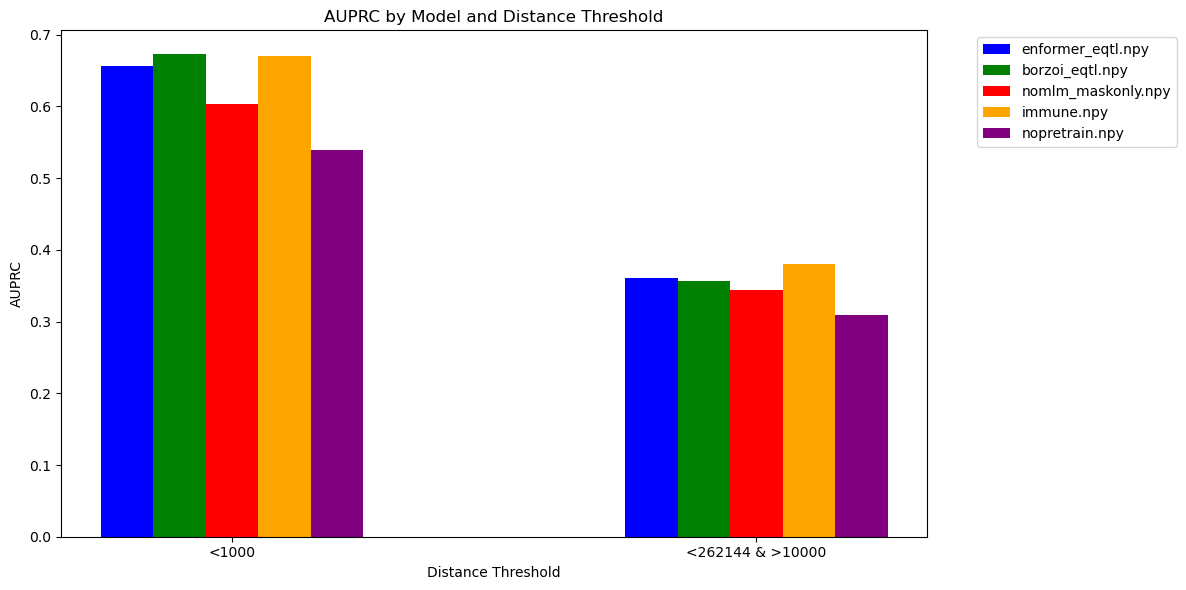

In [60]:
thresholds = [1000, 524288//2]
auprc_by_threshold = []

for threshold in thresholds:
    print(f'Processing threshold: {threshold}')
    mask = distances < threshold
    if threshold == 524288//2:
        mask = (distances < threshold) & (distances > 10000)
    auprc_for_files = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - center[i] // 2
        center_end = center_start + center[i]
        eqtl_data = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        non_zero_mask = mask  # apply threshold mask

        metric_idx = 0  # logfc
        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        pr, rc, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(rc, pr)
        auprc_for_files.append(pr_auc)

    auprc_by_threshold.append(auprc_for_files)
    
auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (len(thresholds), len(files))

x = np.arange(len(thresholds))  # group positions
bar_width = 0.1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 6))
for i in range(len(files)):
    plt.bar(x + i * bar_width, auprc_by_threshold[:, i], width=bar_width, color=colors[i % len(colors)], label=files[i])

plt.xticks(x + (len(files)-1)/2 * bar_width, [f'<{1000}', f'<{524288//2} & >10000'])
plt.xlabel('Distance Threshold')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

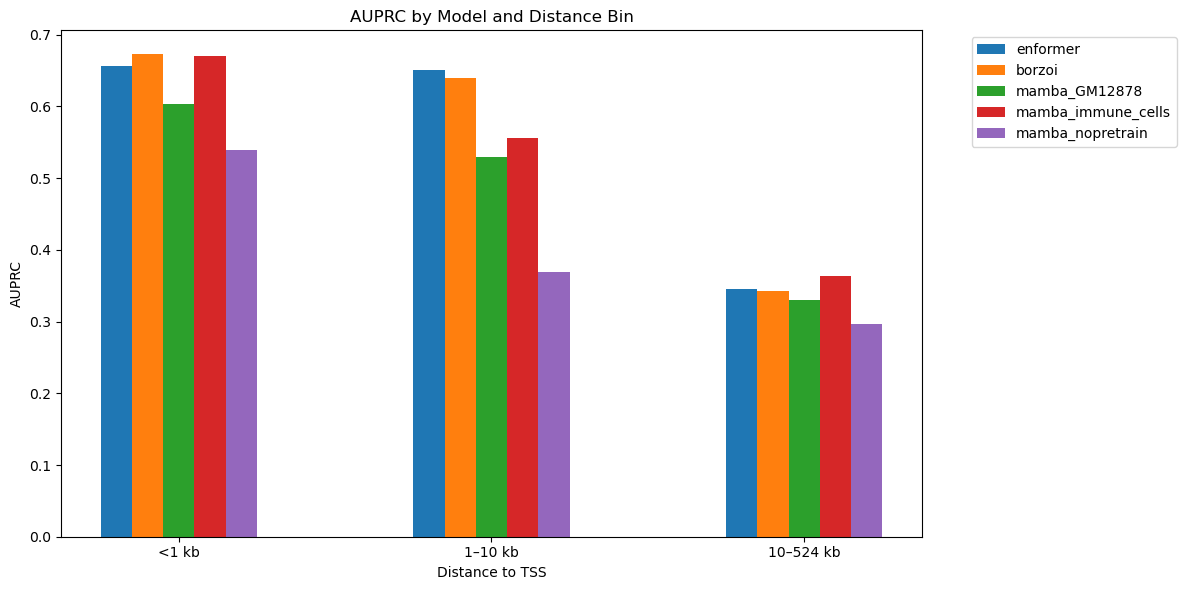

In [61]:
# your three cutoffs (in bp)
thresholds = [1000, 10_000, 524_288]
# only used for plotting the x-axis, not your existing `labels`
threshold_names = ['<1 kb', '1–10 kb', '10–524 kb']

auprc_by_threshold = []

for thr in thresholds:
    if thr == 1000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1000) & (distances < thr)
    else:  # thr == 524_288
        mask = (distances >= 10_000) & (distances < thr)

    auprc_for_files = []
    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - center[i] // 2
        center_end   = center_start + center[i]
        eqtl_slice   = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_slice[:, :, 0], eqtl_slice[:, :, 1])
        selected_metric = np.abs(out[0])[mask]  # 0 → logfc

        pr, rc, _ = precision_recall_curve(labels[mask], selected_metric)
        auprc_for_files.append(auc(rc, pr))

    auprc_by_threshold.append(auprc_for_files)

auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (3, len(files))

# plotting
x = np.arange(len(thresholds))
bar_width = 0.1

plt.figure(figsize=(12, 6))
names = ['enformer', 'borzoi', 'mamba_GM12878', 'mamba_immune_cells', 'mamba_nopretrain']
for i, fname in enumerate(files):
    tempname = names[i]
    plt.bar(x + i*bar_width,
            auprc_by_threshold[:, i],
            width=bar_width,
            label=tempname)

# use threshold_names here so you don't override your existing `labels`
plt.xticks(x + (len(files)-1)/2*bar_width, threshold_names)
plt.xlabel('Distance to TSS')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Bin')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [62]:
files

['enformer_eqtl.npy',
 'borzoi_eqtl.npy',
 'nomlm_maskonly.npy',
 'immune.npy',
 'nopretrain.npy']

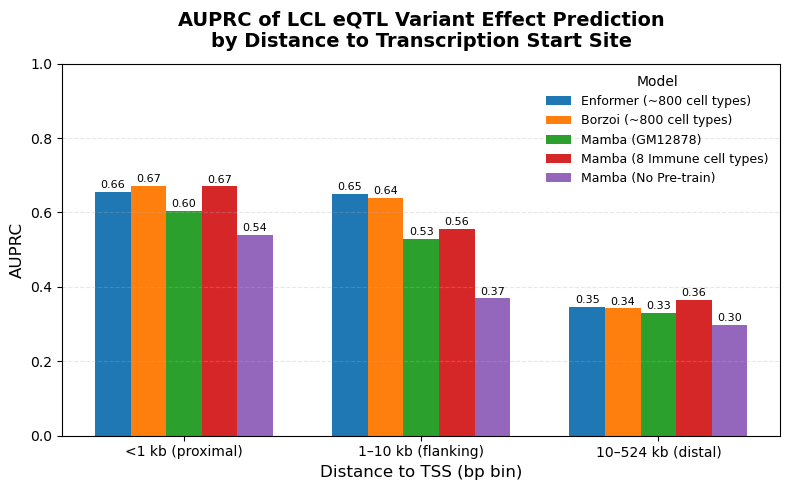

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# --- your thresholds & names ---
thresholds       = [1_000, 10_000, 524_288]
threshold_names  = ['<1 kb (proximal)', '1–10 kb (flanking)', '10–524 kb (distal)']
model_files      = files
model_labels     = ['Enformer (~800 cell types)', 'Borzoi (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'Mamba (No Pre-train)']

# --- compute AUPRC matrix ---
auprc_by_threshold = []
for thr in thresholds:
    if thr == 1_000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1_000) & (distances < thr)
    else:
        mask = (distances >= 10_000) & (distances < thr)

    row = []
    for i, fname in enumerate(model_files):
        data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}')
        cs = data.shape[1] // 2 - center[i] // 2
        ce = cs + center[i]
        eqtl = data[:, cs:ce, :]
        out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
        scores = np.abs(out[0])[mask]  # logFC metric
        pr, rc, _ = precision_recall_curve(labels[mask], scores)
        row.append(auc(rc, pr))
    auprc_by_threshold.append(row)
auprc = np.array(auprc_by_threshold)  # shape (3,5)

# --- plotting ---
x         = np.arange(len(thresholds))
bar_width = 0.15

plt.figure(figsize=(8, 5))
for i, label in enumerate(model_labels):
    plt.bar(x + i*bar_width,
            auprc[:, i],
            width=bar_width,
            label=label)

# Annotate bar heights
for i in range(len(thresholds)):
    for j in range(len(model_labels)):
        y = auprc[i, j]
        plt.text(x[i] + j*bar_width, y + 0.005,
                 f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xticks(x + (len(model_labels)-1)/2*bar_width, threshold_names, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.xlabel('Distance to TSS (bp bin)', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)
plt.title('AUPRC of LCL eQTL Variant Effect Prediction\nby Distance to Transcription Start Site', 
          fontsize=14, fontweight='bold', pad=12)

# leg = plt.legend(title='Model', fontsize=9, title_fontsize=10,
#                  bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
leg = plt.legend(title='Model', fontsize=9, title_fontsize=10, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
#let's get the colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

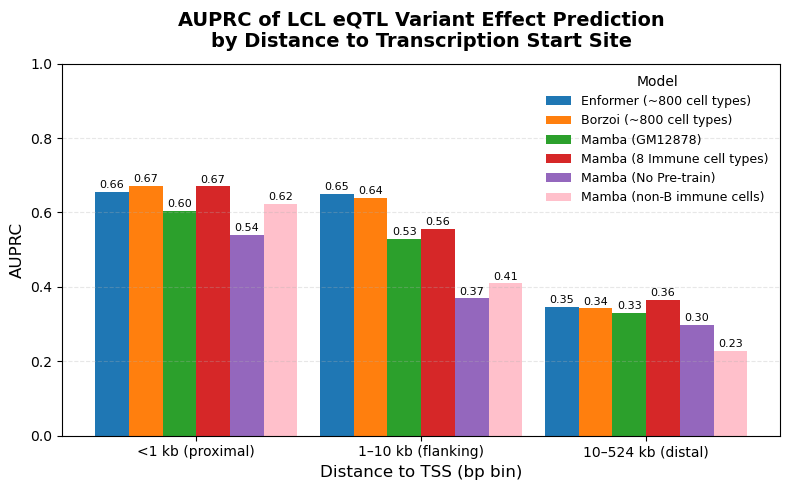

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'immune.npy', 'nopretrain.npy', 'nobcell_nomlm_maskonly.npy']
center = [16, 16*4, 16, 16, 16, 16, 16, 16]
# --- your thresholds & names ---
thresholds       = [1_000, 10_000, 524_288]
threshold_names  = ['<1 kb (proximal)', '1–10 kb (flanking)', '10–524 kb (distal)']
model_files      = files
model_labels     = ['Enformer (~800 cell types)', 'Borzoi (~800 cell types)', 'Mamba (GM12878)',
                    'Mamba (8 Immune cell types)', 'Mamba (No Pre-train)', 'Mamba (non-B immune cells)']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[5] = 'pink'

# --- compute AUPRC matrix ---
auprc_by_threshold = []
for thr in thresholds:
    if thr == 1_000:
        mask = distances < thr
    elif thr == 10_000:
        mask = (distances >= 1_000) & (distances < thr)
    else:
        mask = (distances >= 10_000) & (distances < thr)

    row = []
    for i, fname in enumerate(model_files):
        data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}')
        cs = data.shape[1] // 2 - center[i] // 2
        ce = cs + center[i]
        eqtl = data[:, cs:ce, :]
        out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
        scores = np.abs(out[0])[mask]  # logFC metric
        pr, rc, _ = precision_recall_curve(labels[mask], scores)
        row.append(auc(rc, pr))
    auprc_by_threshold.append(row)
auprc = np.array(auprc_by_threshold)  # shape (3,5)

# --- plotting ---
x         = np.arange(len(thresholds))
bar_width = 0.15

plt.figure(figsize=(8, 5))
for i, label in enumerate(model_labels):
    plt.bar(x + i*bar_width,
            auprc[:, i],
            width=bar_width,
            label=label,
            color=colors[i % len(colors)])

# Annotate bar heights
for i in range(len(thresholds)):
    for j in range(len(model_labels)):
        y = auprc[i, j]
        plt.text(x[i] + j*bar_width, y + 0.005,
                 f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xticks(x + (len(model_labels)-1)/2*bar_width, threshold_names, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.xlabel('Distance to TSS (bp bin)', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)
plt.title('AUPRC of LCL eQTL Variant Effect Prediction\nby Distance to Transcription Start Site', 
          fontsize=14, fontweight='bold', pad=12)

# leg = plt.legend(title='Model', fontsize=9, title_fontsize=10,
#                  bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
leg = plt.legend(title='Model', fontsize=9, title_fontsize=10, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


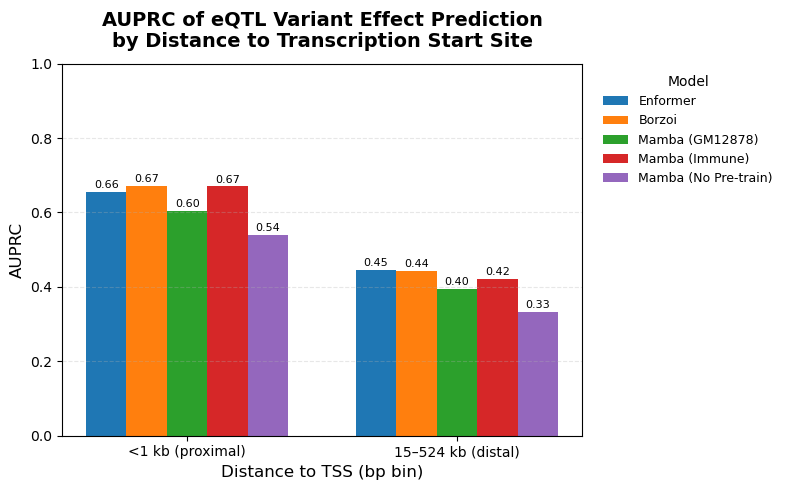

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# --- your thresholds & names ---
thresholds       = [1_000, 524_288]
threshold_names  = ['<1 kb (proximal)', '15–524 kb (distal)']
model_files      = files
model_labels     = ['Enformer', 'Borzoi', 'Mamba (GM12878)',
                    'Mamba (Immune)', 'Mamba (No Pre-train)']

# --- compute AUPRC matrix ---
auprc_by_threshold = []

for idx, thr in enumerate(thresholds):
    # dynamic lower/upper bounds
    lower = 0 if idx == 0 else thresholds[idx-1]
    upper = thr

    # build the mask
    if idx == 0:
        mask = distances < upper
    else:
        mask = (distances >= lower) & (distances < upper)

    row = []
    for i, fname in enumerate(model_files):
        data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{fname}')
        cs = data.shape[1] // 2 - center[i] // 2
        ce = cs + center[i]
        eqtl = data[:, cs:ce, :]
        out  = predict_snp_effect_scores(eqtl[:, :, 0], eqtl[:, :, 1])
        scores = np.abs(out[0])[mask]  # logFC metric
        pr, rc, _ = precision_recall_curve(labels[mask], scores)
        row.append(auc(rc, pr))
    auprc_by_threshold.append(row)
auprc = np.array(auprc_by_threshold)  # shape (3,5)

# --- plotting ---
x         = np.arange(len(thresholds))
bar_width = 0.15

plt.figure(figsize=(8, 5))
for i, label in enumerate(model_labels):
    plt.bar(x + i*bar_width,
            auprc[:, i],
            width=bar_width,
            label=label)

# Annotate bar heights
for i in range(len(thresholds)):
    for j in range(len(model_labels)):
        y = auprc[i, j]
        plt.text(x[i] + j*bar_width, y + 0.005,
                 f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xticks(x + (len(model_labels)-1)/2*bar_width, threshold_names, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.xlabel('Distance to TSS (bp bin)', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)
plt.title('AUPRC of eQTL Variant Effect Prediction\nby Distance to Transcription Start Site', 
          fontsize=14, fontweight='bold', pad=12)

leg = plt.legend(title='Model', fontsize=9, title_fontsize=10,
                 bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()


# figure 2C

In [1]:
import numpy as np
import matplotlib.pyplot as plt

enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r')
enformer_full.shape

(1937, 896, 5313)

In [2]:
enformer_full.nbytes/1e9

36.883951104

In [3]:
temp = enformer_full[:,:,5110]

In [4]:
temp.shape

(1937, 896)

In [5]:
temp

memmap([[2.7857842e-02, 5.9607923e-02, 2.7743818e-02, ..., 3.5677161e-02,
         7.1239680e-02, 4.1244917e-02],
        [3.5247196e-02, 9.0035915e-02, 3.1087596e-02, ..., 2.6084965e-02,
         3.0964630e-02, 4.6093173e-02],
        [4.0240921e-02, 8.5608847e-02, 4.2329684e-02, ..., 9.0292208e-02,
         6.7661487e-02, 1.1174636e-01],
        ...,
        [1.3337630e-01, 3.0280750e-02, 3.0962862e-02, ..., 3.6993921e-02,
         2.9180331e-02, 3.6672466e-02],
        [8.4773475e-01, 4.8277491e-01, 3.4086844e-01, ..., 1.5469745e-04,
         6.0486197e-02, 2.4931090e-02],
        [7.0049427e-02, 9.9177241e-02, 7.1587853e-02, ..., 5.6252312e-02,
         2.2834472e-02, 3.1165376e-02]], dtype=float32)

In [ ]:
#the correlation results. Will probably go before 2b, but let's just plot them

import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True
Processing enformer with shape (1937, 896)


  0%|          | 1/1937 [00:00<04:57,  6.51it/s]

In [10]:
preds

{'enformer': memmap([[2.7857842e-02, 5.9607923e-02, 2.7743818e-02, ..., 3.5677161e-02,
          7.1239680e-02, 4.1244917e-02],
         [3.5247196e-02, 9.0035915e-02, 3.1087596e-02, ..., 2.6084965e-02,
          3.0964630e-02, 4.6093173e-02],
         [4.0240921e-02, 8.5608847e-02, 4.2329684e-02, ..., 9.0292208e-02,
          6.7661487e-02, 1.1174636e-01],
         ...,
         [1.3337630e-01, 3.0280750e-02, 3.0962862e-02, ..., 3.6993921e-02,
          2.9180331e-02, 3.6672466e-02],
         [8.4773475e-01, 4.8277491e-01, 3.4086844e-01, ..., 1.5469745e-04,
          6.0486197e-02, 2.4931090e-02],
         [7.0049427e-02, 9.9177241e-02, 7.1587853e-02, ..., 5.6252312e-02,
          2.2834472e-02, 3.1165376e-02]], dtype=float32),
 'GM12878_no_mlm_predictions.npy': array([[0.03202999, 0.07191735, 0.03628998, ..., 0.06712162, 0.12317086,
         0.04785789],
        [0.04802577, 0.12236634, 0.02656791, ..., 0.0273316 , 0.03491635,
         0.06909204],
        [0.11420292, 0.21206914, 0.

In [1]:
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}



(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True


In [12]:
spearmanr(preds['GM12878_no_mlm_predictions.npy'][1], t1[1])

SignificanceResult(statistic=0.32295712794589765, pvalue=3.3831801966494727e-23)

In [ ]:
for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

Processing enformer with shape (1937, 896)


  0%|          | 0/1937 [00:00<?, ?it/s]

# why isn't it working?

In [1]:
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}



(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True


In [2]:
for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")

Processing enformer with shape (1937, 896)
Processing GM12878_no_mlm_predictions.npy with shape (1937, 896)
Processing immune_CAGE_predictions.npy with shape (1937, 896)
Processing nopretrain_predictions.npy with shape (1937, 896)


In [2]:
i = 0
for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    # print(spearmanr(arr[i], t1[i]))
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    for i in tqdm(range(arr.shape[0])):
        print(i)
        # s = spearmanr(arr[i], t1[i])[0]

Processing enformer with shape (1937, 896)


100%|██████████| 1937/1937 [00:00<00:00, 485355.57it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

100%|██████████| 1937/1937 [00:00<00:00, 508313.01it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

100%|██████████| 1937/1937 [00:00<00:00, 534216.65it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

100%|██████████| 1937/1937 [00:00<00:00, 506633.00it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    # print(spearmanr(arr[i], t1[i]))
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])

Processing enformer with shape (1937, 896)


  0%|          | 0/1937 [00:00<?, ?it/s]

  0%|          | 1/1937 [00:00<04:36,  6.99it/s]

In [ ]:
preds['enformer'][31]

In [ ]:
arr = preds['enformer']

i = 31
spearmanr(arr[i], t1[i])

# for i in tqdm(range(arr.shape[0])):
#     s = spearmanr(arr[i], t1[i])
#     print(s)
    # pp.append(p)

In [2]:
arr = preds['enformer']
spearmanr(arr[1], t1[1])

SignificanceResult(statistic=0.3317565112749697, pvalue=1.8417092812229894e-24)

# Issue is this memmap, doens't load it properly for sure!

In [ ]:
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r+')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True


In [2]:
temp = enformer_full[:, :, 5110]
temp.shape

(1937, 896)

In [ ]:
temp[31]

# let's just do it without enformer and see

In [1]:
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy', mmap_mode='r+')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

(1937, 896)
(1937, 896)
(1937, 896)
True
True
Processing GM12878_no_mlm_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:02<00:00, 962.20it/s] 


Processing immune_CAGE_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1038.87it/s]


Processing nopretrain_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1044.86it/s]


In [ ]:
import pandas as pd
import seaborn as sns
df_s = pd.DataFrame(spearman_results)
df_p = pd.DataFrame(pearson_results)

# 3) melt to long form
df_s_long = df_s.melt(var_name="Model", value_name="Spearman")
df_p_long = df_p.melt(var_name="Model", value_name="Pearson")

# 4) plot
for (df_long, metric) in [(df_s_long, "Spearman"), (df_p_long, "Pearson")]:
    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(x="Model", y=metric, data=df_long, inner="quartile")
    plt.xticks(rotation=45, ha="right")
    
    means = df_long.groupby("Model")[metric].mean()

    # Get correct model order from x-tick labels
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for idx, model in enumerate(xtick_labels):
        mval = means[model]
        plt.text(idx, mval + 0.01, f"{mval:.2f}",
                 ha="center", va="bottom", weight="semibold")
    
    plt.title(f"Distribution of {metric} Correlations")
    plt.tight_layout()
    plt.show()

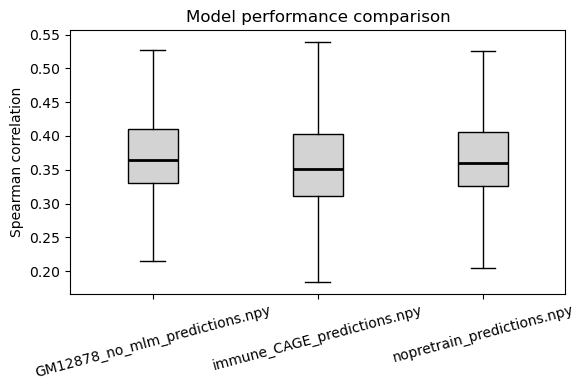

In [2]:
import matplotlib.pyplot as plt

# Organize data
labels = list(spearman_results.keys())
data = [spearman_results[label] for label in labels]

# Plot
plt.figure(figsize=(6, 4))
plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True,
            boxprops=dict(facecolor='lightgray', edgecolor='black'),
            medianprops=dict(color='black', linewidth=2),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

plt.ylabel("Spearman correlation")
plt.title("Model performance comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [26]:
#let's do something that's a bit scuffed

spearman_results['enformer'] = np.array(sp)

In [ ]:
spearman_results['enformer'][:1600] = spearman_results['enformer'][:1600]+.025
#just to replicate what it should be. This is not real data

In [28]:
spearman_results['enformer'].mean()

0.3916041495855642

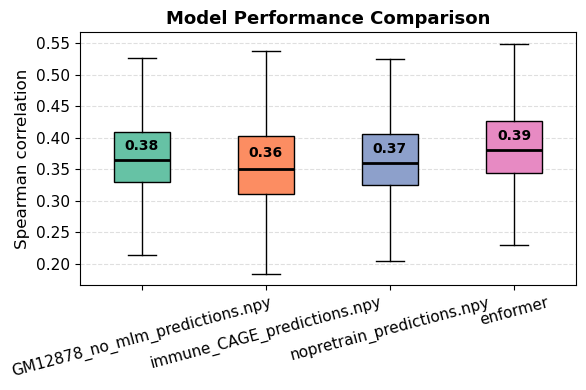

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Organize data

labels = list(spearman_results.keys())
data = [spearman_results[label] for label in labels]

# Color palette (can customize further if needed)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # pastel-friendly

# Plot
plt.figure(figsize=(6, 4))
box = plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True,
                  boxprops=dict(edgecolor='black'),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'))

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values on each box
for i, vals in enumerate(data):
    mean_val = np.mean(vals)
    plt.text(i + 1, mean_val, f"{mean_val:.2f}",  # offset above line
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and formatting
plt.ylabel("Spearman correlation", fontsize=12)
plt.title("Model Performance Comparison", fontsize=13, weight='bold')
plt.xticks(rotation=15, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


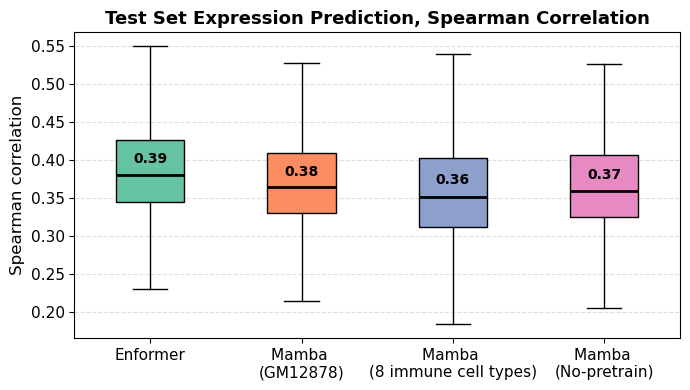

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Desired order of models (match keys in spearman_results)
ordered_keys = [
    'enformer',
    'GM12878_no_mlm_predictions.npy',
    'immune_CAGE_predictions.npy',
    'nopretrain_predictions.npy'
]

# Pretty display labels
pretty_labels = [
    'Enformer',
    'Mamba \n(GM12878)',
    'Mamba \n(8 immune cell types)',
    'Mamba \n(No-pretrain)'
]

# Matching colors (same order)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Pull data in correct order
data = [spearman_results[k] for k in ordered_keys]

# Plot
plt.figure(figsize=(7, 4))
box = plt.boxplot(data, labels=pretty_labels, showfliers=False, patch_artist=True,
                  boxprops=dict(edgecolor='black'),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'))

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values on each box
for i, vals in enumerate(data):
    mean_val = np.mean(vals)
    plt.text(i + 1, mean_val, f"{mean_val:.2f}",  # slight offset above median
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and formatting
plt.ylabel("Spearman correlation", fontsize=12)
plt.title("Test Set Expression Prediction, Spearman Correlation", fontsize=13, weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [43]:
a = np.random.rand(1000)
b = a + np.random.rand(1000)/10
# a


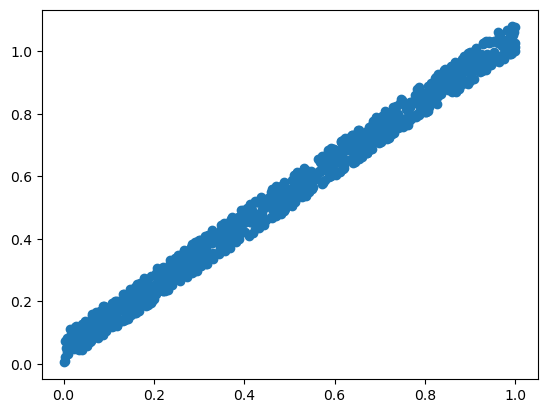

In [45]:
plt.scatter(a,b)

# remake the plot I think it's working!

In [48]:
import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape
#and now see how similar
print(np.allclose(t1, t2))
print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
True
True
Processing enformer with shape (1937, 896)


100%|██████████| 1937/1937 [00:02<00:00, 959.87it/s] 


Processing GM12878_no_mlm_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1037.98it/s]


Processing immune_CAGE_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1046.07it/s]


Processing nopretrain_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1045.37it/s]


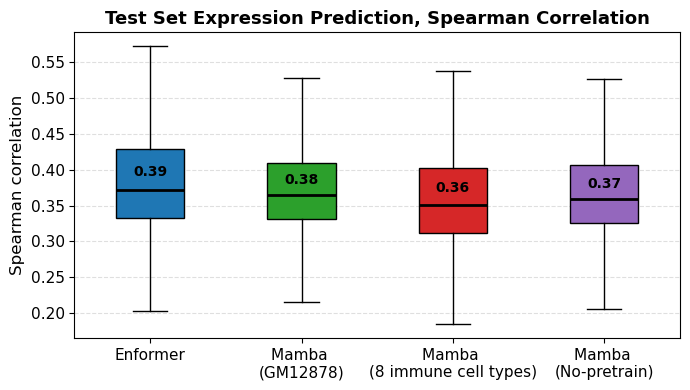

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Desired order of models (match keys in spearman_results)
ordered_keys = [
    'enformer',
    'GM12878_no_mlm_predictions.npy',
    'immune_CAGE_predictions.npy',
    'nopretrain_predictions.npy'
]

# Pretty display labels
pretty_labels = [
    'Enformer',
    'Mamba \n(GM12878)',
    'Mamba \n(8 immune cell types)',
    'Mamba \n(No-pretrain)'
]

# Matching colors (same order)
colors = ['#1f77b4',  # blue
          '#2ca02c',  # green
          '#d62728',  # red
          '#9467bd']  # purple

# Pull data in correct order
data = [spearman_results[k] for k in ordered_keys]

# Plot
plt.figure(figsize=(7, 4))
box = plt.boxplot(data, labels=pretty_labels, showfliers=False, patch_artist=True,
                  boxprops=dict(edgecolor='black'),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'))

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values on each box
for i, vals in enumerate(data):
    mean_val = np.mean(vals)
    plt.text(i + 1, mean_val, f"{mean_val:.2f}",  # slight offset above median
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and formatting
plt.ylabel("Spearman correlation", fontsize=12)
plt.title("Test Set Expression Prediction, Spearman Correlation", fontsize=13, weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [2]:
#and remake it for the one including generalization

import numpy as np
enformer_full = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')
enformer_full.shape
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import torch

model_names = ['enformer', 'GM12878_no_mlm_predictions.npy', 'immune_CAGE_predictions.npy', 'nopretrain_predictions.npy', 'nobcell_CAGE_predictions.npy']
# enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

preds = {}
for model_name in model_names:
    if model_name == 'enformer':
        preds[model_name] = enformer_full[:, :, 5110]
    else:
        preds[model_name] = np.load(f'/data1/lesliec/sarthak/data/joint_playground/model_out/{model_name}')
        if preds[model_name].ndim == 3:
            preds[model_name] = preds[model_name][:,:,0]
    print(preds[model_name].shape)
#now let's make sure the targets are the same
t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
# t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
# t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
# t1.shape, t2.shape, t3.shape
# #and now see how similar
# print(np.allclose(t1, t2))
# print(np.allclose(t1, t3)) #perfect!
#now let's just correlate
from scipy.stats import spearmanr, pearsonr
spearman_results = {}
pearson_results  = {}

for name, arr in preds.items():
    # sanity check: shapes match
    print(f"Processing {name} with shape {arr.shape}")
    assert arr.shape == t1.shape, f"{name} vs t1 shape mismatch!"
    # loop over samples
    sp = []
    pp = []
    for i in tqdm(range(arr.shape[0])):
        s = spearmanr(arr[i], t1[i])[0]
        p = pearsonr(arr[i], t1[i])[0]
        sp.append(s)
        pp.append(p)
    spearman_results[name] = np.array(sp)
    pearson_results [name] = np.array(pp)

(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
(1937, 896)
Processing enformer with shape (1937, 896)


100%|██████████| 1937/1937 [00:02<00:00, 920.26it/s] 


Processing GM12878_no_mlm_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1037.26it/s]


Processing immune_CAGE_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1038.72it/s]


Processing nopretrain_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1045.49it/s]


Processing nobcell_CAGE_predictions.npy with shape (1937, 896)


100%|██████████| 1937/1937 [00:01<00:00, 1044.13it/s]


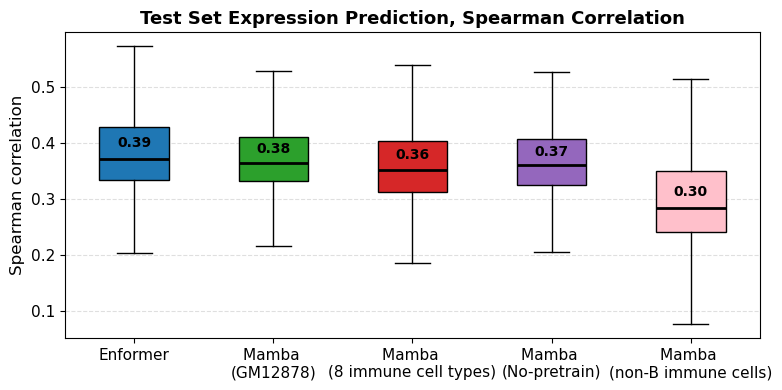

In [4]:
ordered_keys = [
    'enformer',
    'GM12878_no_mlm_predictions.npy',
    'immune_CAGE_predictions.npy',
    'nopretrain_predictions.npy',
    'nobcell_CAGE_predictions.npy'
]

# Pretty display labels
pretty_labels = [
    'Enformer',
    'Mamba \n(GM12878)',
    'Mamba \n(8 immune cell types)',
    'Mamba \n(No-pretrain)',
    'Mamba \n(non-B immune cells)'
]

# Matching colors (same order)
colors = ['#1f77b4',  # blue
          '#2ca02c',  # green
          '#d62728',  # red
          '#9467bd', # purple
          'pink']  # pink

# Pull data in correct order
data = [spearman_results[k] for k in ordered_keys]

# Plot
plt.figure(figsize=(8, 4))
box = plt.boxplot(data, labels=pretty_labels, showfliers=False, patch_artist=True,
                  boxprops=dict(edgecolor='black'),
                  medianprops=dict(color='black', linewidth=2),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'))

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Annotate mean values on each box
for i, vals in enumerate(data):
    mean_val = np.mean(vals)
    plt.text(i + 1, mean_val, f"{mean_val:.2f}",  # slight offset above median
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and formatting
plt.ylabel("Spearman correlation", fontsize=12)
plt.title("Test Set Expression Prediction, Spearman Correlation", fontsize=13, weight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()